In [ ]:
# =========================================================
# SEÇÃO 1: IMPORTAÇÕES E SETUP GERAL
# =========================================================

In [ ]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Libs de Modelagem e Estatística
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.datasets import get_rdataset
from scipy.stats import friedmanchisquare
import pmdarima as pm
import scikit_posthocs as sp
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, MLP, LSTM, Autoformer, NHITS

# Libs de Avaliação
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from IPython.display import display, Markdown

In [ ]:
# =========================================================
# SEÇÃO 2: FUNÇÕES AUXILIARES (SETUP E PROCESSAMENTO)
# =========================================================

In [ ]:
def definir_seed(seed_value=42):
    np.random.seed(seed_value)
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

In [ ]:
def carregar_serie(nome, pasta_cache="./data/bronze"):
    """
    Carrega uma série temporal de forma eficiente.

    Primeiro, verifica se existe uma cópia local em cache (arquivo .csv).
    Se existir, carrega diretamente do arquivo.
    Se não, faz o download via statsmodels e salva uma cópia em cache para uso futuro.
    """
    nome_base = nome.lower()
    # Garante que o diretório de cache exista
    os.makedirs(pasta_cache, exist_ok=True)
    caminho_arquivo = os.path.join(pasta_cache, f"{nome_base}.csv")

    # Passo 1: Verifica se o arquivo já existe localmente
    if os.path.exists(caminho_arquivo):
        print(f"Carregando dataset '{nome}' do cache local: {caminho_arquivo}")
        # Se existir, carrega diretamente do CSV, garantindo que a data seja o índice
        df = pd.read_csv(caminho_arquivo, parse_dates=['date'], index_col='date')
        # Retorna a série com o nome original para consistência
        df['value'].name = nome
        return df['value']

    # Passo 2: Se não existir, faz o download
    print(f"Cache não encontrado. Buscando dados de '{nome}' via statsmodels...")
    
    serie = None
    if nome_base == "airpassengers":
        dados = get_rdataset("AirPassengers", package="datasets").data
        serie = pd.Series(dados['value'].values, index=pd.date_range(start="1949-01-01", periods=len(dados), freq="MS"), name=nome)
    elif nome_base == "lynx":
        dados = get_rdataset("lynx", package="datasets").data
        serie = pd.Series(dados['value'].values, index=pd.date_range(start="1821", periods=len(dados), freq="YE-DEC"), name=nome)
    elif nome_base == "co2":
        dados = get_rdataset("CO2", package="datasets").data
        dados = dados.ffill()
        serie = pd.Series(dados['value'].values, index=pd.date_range(start="1958-03-29", periods=len(dados), freq="MS"), name=nome)
    elif nome_base == "austres":
        dados = get_rdataset("austres", package="datasets").data
        serie = pd.Series(dados['value'].values, index=pd.date_range(start="1971-03-01", periods=len(dados), freq="QS-MAR"), name=nome)
    elif nome_base == "nottem":
        dados = get_rdataset("nottem", package="datasets").data
        serie = pd.Series(dados['value'].values, index=pd.date_range(start="1920-01-01", periods=len(dados), freq="MS"), name=nome)
    else:
        raise ValueError(f"Lógica de download para a série '{nome}' não implementada.")

    # Passo 3: Salva a série baixada no cache para uso futuro
    if serie is not None:
        print(f"-> Salvando cópia do dataset '{nome}' em cache: {caminho_arquivo}")
        df_para_salvar = pd.DataFrame({"date": serie.index, "value": serie.values})
        df_para_salvar.to_csv(caminho_arquivo, index=False)
    
    return serie

In [ ]:
def dividir_serie_temporal(serie, percentual_treino=0.85):
    tamanho_total = len(serie)
    ponto_corte_treino = int(tamanho_total * percentual_treino)
    treino = serie.iloc[:ponto_corte_treino]
    teste = serie.iloc[ponto_corte_treino:]
    return treino, teste

def preparar_dados_para_neuralforecast(serie, nome_serie):
    df = serie.reset_index()
    df.columns = ['ds', 'y']
    df['unique_id'] = nome_serie
    return df

In [ ]:
# =========================================================
# SEÇÃO 3: FUNÇÕES PARA CÁLCULO DE MÉTRICAS E MODELAGEM
# =========================================================

In [ ]:
def calcular_metricas(y_true, y_pred, y_train):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true != 0) else np.inf
    n = len(y_train)
    d = np.sum(np.abs(y_train[1:] - y_train[:-1])) / (n - 1) if n > 1 else np.nan
    mase = np.mean(np.abs(y_true - y_pred)) / d if d is not np.nan and d > 0 else np.inf
    return {'RMSE': rmse, 'MAPE(%)': mape, 'MASE': mase}

In [ ]:
# =========================================================
# SEÇÃO 4: PIPELINE AVANÇADO PARA O ARIMA
# =========================================================


In [ ]:
def encontrar_melhor_arima_auto(treino_log, freq):
    """Usa auto_arima para encontrar a melhor ordem ARIMA, incluindo sazonalidade."""
    print("Buscando melhor ordem ARIMA com auto_arima...")
    m = 12 if freq.startswith('M') else (4 if freq.startswith('Q') else 1)
    auto_arima_model = pm.auto_arima(treino_log, m=m, seasonal=True, trace=False, error_action='ignore', suppress_warnings=True, stepwise=True)
    print(f"Melhor ordem encontrada: {auto_arima_model.order} Sazonal: {auto_arima_model.seasonal_order}")
    return auto_arima_model.order, auto_arima_model.seasonal_order

In [ ]:
# =========================================================
# SEÇÃO 5: PIPELINE DE EXPERIMENTO COMPLETO E AVANÇADO
# =========================================================

In [ ]:
def executar_experimento(nome_da_serie, horizonte):
    """Executa o pipeline completo com as correções de estabilidade."""
    try:
        SEED = 42;
        definir_seed(SEED)
        MAX_INPUT_SIZE = 24;
        MAX_STEPS_NEURAL = 150
        
        serie_original = carregar_serie(nome_da_serie)
        
        percentual_treino = 1 - (horizonte / len(serie_original))
        if percentual_treino < 0.5: # Garante pelo menos 50% de dados para treino
             print(f"AVISO: Horizonte {horizonte} é muito grande para a série '{nome_da_serie}'. Pulando.")
             return None
        
        treino_orig, teste_orig = dividir_serie_temporal(serie_original, percentual_treino=percentual_treino)
        serie_log = np.log(serie_original)
        treino_log, _ = dividir_serie_temporal(serie_log, percentual_treino=percentual_treino)
        
        freq = serie_original.index.freqstr or pd.infer_freq(serie_original.index)
        if freq is None: return None

        previsoes_teste = {'y_true': teste_orig.values}
        
        # --- 1. Modelo ARIMA ---
        modelo_arima = None
        try:
            print("Processando: ARIMA")
            ordem, ordem_sazonal = encontrar_melhor_arima_auto(treino_log, freq)
            modelo_arima = ARIMA(treino_log.asfreq(freq), order=ordem, seasonal_order=ordem_sazonal).fit()
            # CORREÇÃO: Usando .forecast() para previsão out-of-sample
            preds_log_teste_arima = modelo_arima.forecast(steps=horizonte)
            previsoes_teste['ARIMA'] = np.exp(preds_log_teste_arima).values
        except Exception as e: print(f"AVISO: ARIMA falhou: {e}")

        # --- 2. Modelos Neurais Puros ---
        df_treino_log_nf = preparar_dados_para_neuralforecast(treino_log, nome_da_serie)
        modelos_para_testar = {'N-BEATS': NBEATS, 'MLP': MLP, 'LSTM': LSTM, 'Autoformer': Autoformer, 'NHITS': NHITS}
        
        for nome_modelo, classe_modelo in modelos_para_testar.items():
            try:
                print(f"Processando: {nome_modelo}")
                # CORREÇÃO: Removida a configuração de arquitetura customizada para N-BEATS/NHITS
                modelo_neural = [classe_modelo(input_size=min(2 * horizonte, MAX_INPUT_SIZE), h=horizonte, max_steps=MAX_STEPS_NEURAL, scaler_type='standard', random_seed=SEED)]
                nf = NeuralForecast(models=modelo_neural, freq=freq)
                nf.fit(df=df_treino_log_nf, verbose=False)
                previsoes_teste[nome_modelo] = np.exp(nf.predict()[classe_modelo.__name__].values)
            except Exception as e: print(f"AVISO: {nome_modelo} falhou: {e}")
        
        # --- 3. Modelo Híbrido (MIMO) ---
        if 'ARIMA' in previsoes_teste and modelo_arima is not None:
            try:
                print("Processando: Híbrido (MIMO)")
                residuos_treino_log = modelo_arima.resid
                df_residuos_nf = preparar_dados_para_neuralforecast(residuos_treino_log, "residuos")
                modelo_residuos = [NBEATS(input_size=min(2*horizonte, MAX_INPUT_SIZE), h=horizonte, max_steps=MAX_STEPS_NEURAL, scaler_type='standard', random_seed=SEED)]
                nf_residuos = NeuralForecast(models=modelo_residuos, freq=freq)
                nf_residuos.fit(df=df_residuos_nf, verbose=False)
                preds_residuos_log = nf_residuos.predict()['NBEATS'].values
                previsoes_teste['Híbrido (MIMO)'] = previsoes_teste['ARIMA'] + preds_residuos_log
            except Exception as e: print(f"AVISO: Híbrido (MIMO) falhou: {e}")
            
        df_final = pd.DataFrame(previsoes_teste, index=teste_orig.index)
        df_final['dataset'] = nome_da_serie
        df_final['horizonte'] = horizonte
        return df_final.reset_index().rename(columns={'index': 'ds'})
    except Exception as e:
        print(f"ERRO GERAL no processamento de '{nome_da_serie}' para o horizonte {horizonte}: {e}")

In [ ]:
# =========================================================
# SEÇÃO 6: ORQUESTRADOR
# =========================================================

In [ ]:
LISTA_DE_DATASETS = ['AirPassengers', 'co2', 'nottem', 'austres', 'lynx'] 
VETOR_DE_HORIZONTES = [10, 12, 15, 24]
resultados_gerais = []
output_dir = "./data/silver"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "resultados_completos.csv")

In [ ]:
for dataset in tqdm(LISTA_DE_DATASETS, desc="Processando Datasets"):
    for horizonte in tqdm(VETOR_DE_HORIZONTES, desc=f"Testando Horizontes para {dataset}", leave=False):
        df_resultado_detalhado = executar_experimento(dataset, horizonte)
        if df_resultado_detalhado is not None:
            resultados_gerais.append(df_resultado_detalhado)

In [ ]:
if resultados_gerais:
    df_final = pd.concat(resultados_gerais)
    df_final.to_csv(output_file, index=False)
    print(f"\nArquivo '{output_file}' salvo com sucesso!")

In [ ]:
# =================================================================================
# SEÇÃO 7: GERAÇÃO DE RELATÓRIOS (ARQUITETURA MODULAR)
# =================================================================================

In [45]:
# --- 7.1 Funções Auxiliares para Geração de Relatórios ---
def calcular_metricas_finais(df_results):
    """
    Função auxiliar para carregar os dados de treino e calcular as métricas
    a partir do DataFrame de previsões brutas.
    """
    modelos = [col for col in df_results.columns if col not in ['ds', 'y_true', 'dataset', 'horizonte']]
    
    # Carrega os dados de treino uma vez para o cálculo do MASE
    y_train_dict = {}
    for dataset_nome in df_results['dataset'].unique():
        treino, _ = dividir_serie_temporal(carregar_serie(dataset_nome))
        y_train_dict[dataset_nome] = treino.values

    # Transforma o DataFrame de 'largo' para 'longo' para facilitar o groupby
    df_melted = df_results.melt(id_vars=['ds', 'y_true', 'dataset', 'horizonte'], value_vars=modelos, var_name='Modelo', value_name='y_pred')
    
    metricas_gerais = []
    # Agrupa para calcular as métricas para cada combinação
    for (dataset, horizonte, modelo), group in df_melted.groupby(['dataset', 'horizonte', 'Modelo']):
        if not group['y_pred'].isnull().all():
            metricas = calcular_metricas(group['y_true'], group['y_pred'], y_train_dict[dataset])
            metricas['dataset'], metricas['horizonte'], metricas['Modelo'] = dataset, horizonte, modelo
            metricas_gerais.append(metricas)
    
    df_metricas_final = pd.DataFrame(metricas_gerais)
    df_metricas_final.rename(columns={'RMSE': 'Mean RMSE', 'MAPE(%)': 'Mean MAPE(%)', 'MASE': 'Mean MASE'}, inplace=True)
    return df_metricas_final

In [46]:
def plotar_evolucao_erro(df_metricas, vetor_horizontes):
    """RELATÓRIO 1: Gera o gráfico de linha da evolução do erro."""
    print("\n--- RELATÓRIO 1: EVOLUÇÃO DO ERRO (RMSE) POR HORIZONTE ---")
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=df_metricas, x='horizonte', y='Mean RMSE', hue='Modelo', style='Modelo', markers=True, dashes=False)
    plt.title("Evolução do Erro (RMSE) com o Aumento do Horizonte", fontsize=16)
    plt.xlabel("Horizonte de Previsão"); plt.ylabel("RMSE Médio"); plt.grid(True)
    if not df_metricas.empty:
        plt.xticks(vetor_horizontes)
    plt.legend(title='Modelo'); plt.show()

In [47]:
def exibir_desempenho_agregado(df_foco):
    """RELATÓRIO 2: Mostra a tabela de desempenho geral agregado."""
    print("\n--- RELATÓRIO 2: DESEMPENHO GERAL (MÉDIA NO HORIZONTE MAIS LONGO) ---")
    df_agrupado = df_foco.groupby('Modelo')[['Mean RMSE', 'Mean MAPE(%)', 'Mean MASE']].mean()
    display(df_agrupado.style.format('{:.3f}').highlight_min(axis=0, props='background-color: #4285F4; color: white;'))

In [48]:
def exibir_desempenho_detalhado(df_foco):
    """RELATÓRIO 3: Mostra a tabela de desempenho detalhado por dataset."""
    print("\n--- RELATÓRIO 3: DESEMPENHO DETALHADO POR DATASET (HORIZONTE MAIS LONGO) ---")
    df_reporte_detalhado = df_foco.set_index(['dataset', 'Modelo']).drop(columns=['horizonte'])
    display(df_reporte_detalhado.style.format('{:.3f}'))

In [49]:
def exibir_tabela_ranking(df_foco):
    """RELATÓRIO 4: Mostra a tabela de ranking e a retorna para uso posterior."""
    print("\n--- RELATÓRIO 4: RANKING DOS MODELOS (BASEADO EM RMSE, HORIZONTE MAIS LONGO) ---")
    df_rank = df_foco.copy()
    df_rank['Rank'] = df_rank.groupby('dataset')['Mean RMSE'].rank().astype(int)
    df_pivot_rank = df_rank.pivot_table(index='dataset', columns='Modelo', values='Rank')
    if len(df_pivot_rank) > 1:
        df_pivot_rank.loc['Média do Rank'] = df_pivot_rank.mean(axis=0)
    display(df_pivot_rank.style.format('{:.1f}').highlight_min(axis=1, props='background-color: #4285F4; color: white;'))
    return df_pivot_rank

In [50]:
def plotar_diferenca_percentual(df_foco):
    """RELATÓRIO 5: Mostra o gráfico de ganho percentual do modelo híbrido."""
    print("\n--- RELATÓRIO 5: GANHO PERCENTUAL DO MODELO HÍBRIDO (BASEADO EM MAPE, HORIZONTE MAIS LONGO) ---")
    df_pivot_mape = df_foco.pivot_table(index='dataset', columns='Modelo', values='Mean MAPE(%)')
    modelo_referencia_hibrido = 'Híbrido (MIMO)'
    if modelo_referencia_hibrido in df_pivot_mape.columns:
        mape_hibrido = df_pivot_mape[modelo_referencia_hibrido]
        df_pd = pd.DataFrame(index=df_pivot_mape.index)
        for modelo in [m for m in df_pivot_mape.columns if m != modelo_referencia_hibrido]:
            df_pd[f'Ganho sobre {modelo} (%)'] = 100 * (df_pivot_mape[modelo] - mape_hibrido) / df_pivot_mape[modelo]
        ax = df_pd.plot(kind='bar', figsize=(14, 7), grid=True, rot=45); ax.set_ylabel("Melhora Percentual (%)"); ax.set_xlabel("Dataset")
        ax.set_title(f"Diferença Percentual (PD%): Ganho de Performance do {modelo_referencia_hibrido}"); plt.tight_layout(); plt.show()

In [51]:
def exibir_analise_estatistica_demsar(df_pivot_rank, maior_horizonte):
    """RELATÓRIO 6: Executa e exibe os testes de Friedman e Nemenyi."""
    print("\n\n" + "="*60); print(f"     RELATÓRIO 6: ANÁLISE ESTATÍSTICA GLOBAL (FRIEDMAN + NEMENYI, HORIZONTE {int(maior_horizonte)})"); print("="*60)
    
    # --- CORREÇÃO APLICADA AQUI ---
    # Inicializamos as variáveis como None para garantir que sempre existam.
    p_values_nemenyi = None
    avg_ranks = None
    
    df_rank_data = df_pivot_rank.drop('Média do Rank', errors='ignore')
    if df_rank_data.empty:
        print("AVISO: Tabela de ranking vazia, não foi possível executar a análise estatística.")
        # Retorna os valores nulos
        return p_values_nemenyi, avg_ranks

    try:
        stat, p_value = friedmanchisquare(*[df_rank_data[col].values for col in df_rank_data.columns])
        print(f"\n--- Teste de Friedman ---\np-valor: {p_value:.4f}")

        if p_value < 0.05:
            print("\n**Conclusão: Há uma diferença estatisticamente significativa entre os modelos.**")
            
            print("\n--- Teste Post-hoc de Nemenyi (p-valores par a par) ---")
            df_rank_melted = df_rank_data.reset_index().melt(id_vars='dataset', var_name='Modelo', value_name='Rank')
            p_values_nemenyi = sp.posthoc_nemenyi_friedman(df_rank_melted, melted=True, group_col='Modelo', block_col='dataset', y_col='Rank')
            display(p_values_nemenyi.style.format('{:.3f}').applymap(lambda x: 'background-color: lightgreen' if x < 0.05 else ''))

            # Calcula os ranks médios apenas se o teste for significativo
            avg_ranks = df_pivot_rank.mean(axis=0).drop('Média do Rank', errors='ignore')
        else:
            print("\n**Conclusão: Não há evidência de uma diferença estatística significativa entre os modelos.**")
            
    except Exception as e:
        print(f"AVISO: A análise estatística avançada falhou: {e}")
        
    # A função agora sempre retorna uma tupla, mesmo que os valores sejam None
    return p_values_nemenyi, avg_ranks    

In [52]:
def plotar_diagrama_diferenca_critica(p_values_nemenyi, avg_ranks, alpha=0.05):
    """RELATÓRIO ADICIONAL: Gera o Diagrama de Diferença Crítica."""
    if p_values_nemenyi is None or avg_ranks is None:
        return # Não plota se os testes anteriores não foram significativos

    print("\n--- DIAGRAMA DE DIFERENÇA CRÍTICA (CD PLOT) ---")
    display(Markdown("Este gráfico resume o teste de Nemenyi. Modelos que **NÃO** são significativamente diferentes estão conectados por uma linha horizontal."))
    
    # Usa a função sign_plot da biblioteca scikit-posthocs
    # Ela automaticamente desenha o diagrama com base nos p-valores de Nemenyi
    sp.sign_plot(p_values_nemenyi, y_lim=(-1, 1), avg_ranks=avg_ranks)
    plt.title(f"Diagrama de Diferença Crítica (Teste de Nemenyi)", fontsize=16)
    plt.show()

In [53]:
# --- NOVA FUNÇÃO DE RELATÓRIO (BASEADA NA TABELA 4 DO ARTIGO) ---
def exibir_tabela_ranking(df_foco, metrica='Mean RMSE'):
    """RELATÓRIO 4: Mostra a tabela de ranking dos modelos."""
    print(f"\n--- RELATÓRIO 4: RANKING DOS MODELOS (BASEADO EM {metrica}) ---")
    df_rank = df_foco.copy()
    rank_col_name = f'Rank_{metrica}'
    df_rank[rank_col_name] = df_rank.groupby('dataset')[metrica].rank().astype(int)
    df_pivot_rank = df_rank.pivot_table(index='dataset', columns='Modelo', values=rank_col_name)
    if len(df_pivot_rank) > 1:
        df_pivot_rank.loc['Média do Rank'] = df_pivot_rank.mean(axis=0)
    display(df_pivot_rank.style.format('{:.1f}').highlight_min(axis=1, props='background-color: #4285F4; color: white;'))
    return df_pivot_rank

# --- NOVA FUNÇÃO DE RELATÓRIO (BASEADA NA TABELA 4 DO ARTIGO) ---
def exibir_ranking_mape_artigo(df_foco):
    """RELATÓRIO EXTRA 1: Gera a tabela de ranking por MAPE, no estilo da Tabela 4 do artigo."""
    print("\n\n" + "="*60)
    print("     RELATÓRIO ADICIONAL: TABELA DE RANKING POR MAPE (ESTILO ARTIGO)")
    print("="*60)
    
    df_rank_mape = df_foco.copy()
    df_rank_mape['Rank_MAPE'] = df_rank_mape.groupby('dataset')['Mean MAPE(%)'].rank().astype(int)
    df_pivot = df_rank_mape.pivot_table(index='Modelo', columns='dataset', values='Rank_MAPE')
    
    # Calcula a Média e Mediana do Rank para cada modelo
    df_pivot['Média'] = df_pivot.mean(axis=1)
    df_pivot['Mediana'] = df_pivot.median(axis=1)
    
    def highlight_top3(s):
        is_top3 = s <= 3
        return ['background-color: blue' if v else '' for v in is_top3]

    styled_pivot = (df_pivot.style
                    .format('{:.1f}')
                    .apply(highlight_top3, subset=pd.IndexSlice[:, [c for c in df_pivot.columns if c not in ['Média', 'Mediana']]])
                    .set_caption("Ranking dos modelos por dataset baseado no MAPE (1 = Melhor)."))
    
    display(styled_pivot)

# --- NOVA FUNÇÃO DE RELATÓRIO (BASEADA NA FIGURA 9 DO ARTIGO) ---
def plotar_pd_agregado(df_foco):
    """RELATÓRIO EXTRA 2: Gera o gráfico de Diferença Percentual (PD%) agregado."""
    print("\n\n" + "="*60)
    print("     RELATÓRIO ADICIONAL: GRÁFICO DE DIFERENÇA PERCENTUAL AGREGADO (ESTILO FIGURA 9)")
    print("="*60)

    modelo_referencia_hibrido = 'Híbrido (MIMO)'
    # Calcula o MAPE médio para cada modelo, em todos os datasets
    df_mean_mape = df_foco.groupby('Modelo')['Mean MAPE(%)'].mean()

    if modelo_referencia_hibrido in df_mean_mape.index:
        mape_hibrido = df_mean_mape[modelo_referencia_hibrido]
        pd_values = []
        for modelo, mape_medio in df_mean_mape.items():
            if modelo != modelo_referencia_hibrido:
                pd_value = 100 * (mape_medio - mape_hibrido) / mape_medio
                pd_values.append({'Modelo': modelo, 'PD(%)': pd_value})
        
        if pd_values:
            df_pd = pd.DataFrame(pd_values).sort_values(by='PD(%)')
            
            plt.figure(figsize=(14, 8))
            ax = sns.barplot(x='Modelo', y='PD(%)', data=df_pd, palette='viridis', hue='Modelo', legend=False)
            ax.set_title(f"Diferença Percentual (PD%) Agregada do {modelo_referencia_hibrido}", fontsize=16)
            ax.set_ylabel("Melhora Percentual (%)")
            ax.set_xlabel("Modelo Competidor")
            plt.grid(axis='x', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()


In [54]:
# --- NOVA FUNÇÃO DE RELATÓRIO ---
def plotar_evolucao_ranking_mape(df_metricas, vetor_horizontes):
    """
    RELATÓRIO NOVO: Gera o gráfico de linha da evolução do Ranking Médio por horizonte,
    baseado no MAPE.
    """
    print("\n\n" + "="*60)
    print("     RELATÓRIO NOVO: EVOLUÇÃO DO RANKING MÉDIO (MAPE) POR HORIZONTE")
    print("="*60)
    
    # Cria uma cópia para trabalhar com segurança
    df_rank_mape = df_metricas.copy()
    
    # Calcula o ranking baseado em MAPE para cada dataset e horizonte
    df_rank_mape['Rank_MAPE'] = df_rank_mape.groupby(['dataset', 'horizonte'])['Mean MAPE(%)'].rank().astype(int)
    
    # Calcula o rank médio para cada modelo em cada horizonte, através de todos os datasets
    df_avg_rank = df_rank_mape.groupby(['horizonte', 'Modelo'])['Rank_MAPE'].mean().reset_index()
    
    plt.figure(figsize=(14, 8))
    ax = sns.lineplot(
        data=df_avg_rank,
        x='horizonte',
        y='Rank_MAPE',
        hue='Modelo',
        style='Modelo',
        markers=True,
        dashes=False,
        linewidth=2.5
    )
    ax.set_title("Evolução do Ranking Médio dos Modelos com o Aumento do Horizonte", fontsize=16)
    ax.set_xlabel("Horizonte de Previsão (Passos à Frente)")
    ax.set_ylabel("Ranking Médio (Menor é Melhor)")
    ax.grid(True)
    ax.set_xticks(vetor_horizontes)
    
    # Inverte o eixo Y para que o rank 1 (melhor) fique no topo
    ax.invert_yaxis()
    
    # Ajusta os ticks do eixo Y para serem inteiros
    y_ticks = np.arange(1, int(df_avg_rank['Rank_MAPE'].max()) + 2)
    ax.set_yticks(y_ticks)
    
    ax.legend(title='Modelo')
    plt.show()

In [55]:
def gerar_suite_completa_de_relatorios(output_file, vetor_horizontes):
    """Função principal que orquestra a geração de todos os relatórios."""
    print("\n\n" + "="*60); print("     INICIANDO GERAÇÃO DA SUÍTE COMPLETA DE RELATÓRIOS"); print("="*60)
    try:
        df_results = pd.read_csv(output_file)
        df_metricas_final = calcular_metricas_finais(df_results)
        
        # Chamada para os relatórios descritivos
        plotar_evolucao_erro(df_metricas_final, vetor_horizontes)
        plotar_evolucao_ranking_mape(df_metricas_final, vetor_horizontes)
        
        maior_horizonte = df_metricas_final['horizonte'].max()
        df_foco_maior_h = df_metricas_final[df_metricas_final['horizonte'] == maior_horizonte]
        display(Markdown(f"### Análises Detalhadas para o Horizonte Mais Longo ({int(maior_horizonte)} passos)"))
        
        exibir_desempenho_agregado(df_foco_maior_h)
        exibir_desempenho_detalhado(df_foco_maior_h)
        df_pivot_rank = exibir_tabela_ranking(df_foco_maior_h)
        plotar_diferenca_percentual(df_foco_maior_h)
        # --- CHAMADA PARA OS NOVOS RELATÓRIOS ---
        exibir_ranking_mape_artigo(df_foco_maior_h)
        plotar_pd_agregado(df_foco_maior_h)
        
        # Chamada para a nova análise estatística
        p_values_nemenyi, avg_ranks = exibir_analise_estatistica_demsar(df_pivot_rank, maior_horizonte)
        
        # Chamada para o novo gráfico
        plotar_diagrama_diferenca_critica(p_values_nemenyi, avg_ranks)

    except FileNotFoundError:
        print(f"\nERRO: Arquivo '{output_file}' não encontrado.")
    except Exception as e:
        print(f"Ocorreu um erro ao gerar os relatórios: {e}")

In [56]:
# =================================================================================
# SEÇÃO 8: EXECUÇÃO DA GERAÇÃO DE RELATÓRIOS
# =================================================================================



     INICIANDO GERAÇÃO DA SUÍTE COMPLETA DE RELATÓRIOS
Carregando dataset 'AirPassengers' do cache local: ./data/bronze\airpassengers.csv
Carregando dataset 'co2' do cache local: ./data/bronze\co2.csv
Carregando dataset 'nottem' do cache local: ./data/bronze\nottem.csv
Carregando dataset 'austres' do cache local: ./data/bronze\austres.csv
Carregando dataset 'lynx' do cache local: ./data/bronze\lynx.csv

--- RELATÓRIO 1: EVOLUÇÃO DO ERRO (RMSE) POR HORIZONTE ---


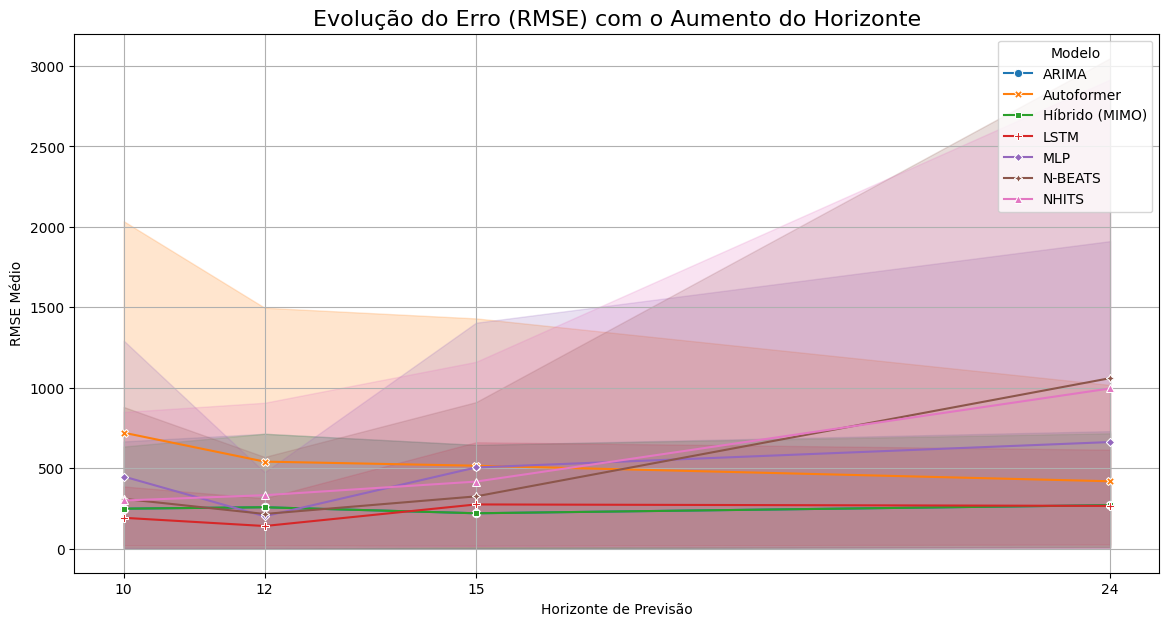



     RELATÓRIO NOVO: EVOLUÇÃO DO RANKING MÉDIO (MAPE) POR HORIZONTE


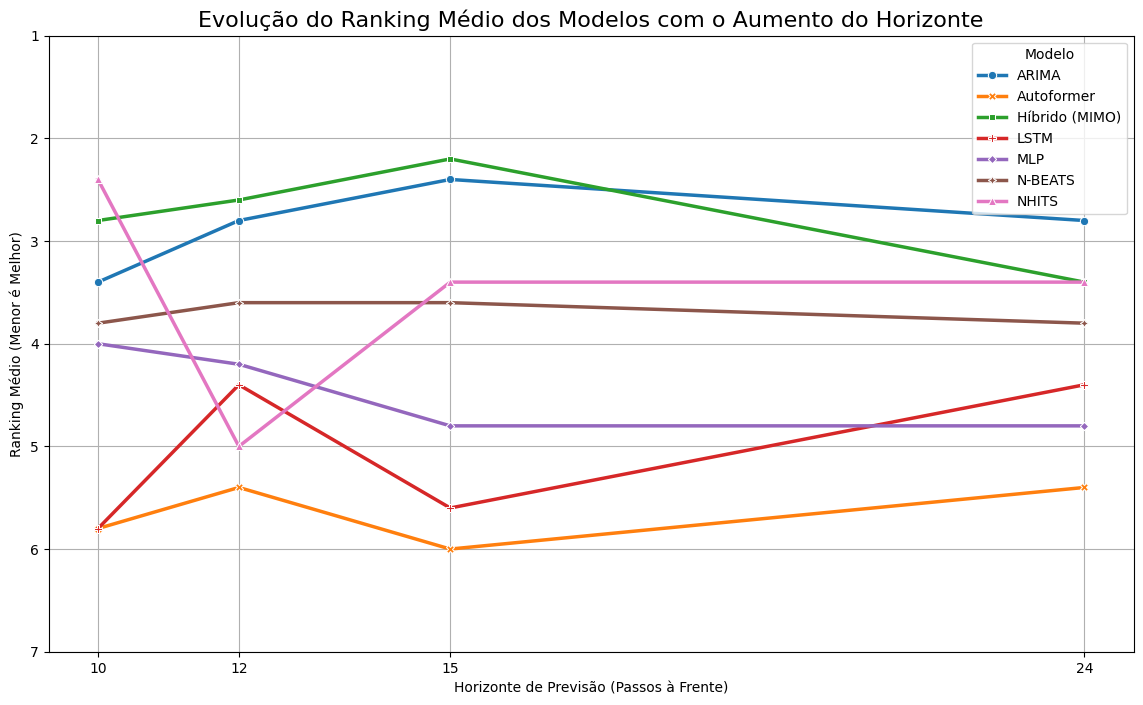

### Análises Detalhadas para o Horizonte Mais Longo (24 passos)


--- RELATÓRIO 2: DESEMPENHO GERAL (MÉDIA NO HORIZONTE MAIS LONGO) ---


,Mean RMSE,Mean MAPE(%),Mean MASE
Modelo,,,
ARIMA,271.030,21.995,1.194
Autoformer,419.649,33.604,2.830
Híbrido (MIMO),271.030,22.001,1.194
LSTM,266.666,18.797,4.072
MLP,663.353,150.912,1.374
N-BEATS,1060.196,104.858,1.703
NHITS,996.294,106.132,1.430



--- RELATÓRIO 3: DESEMPENHO DETALHADO POR DATASET (HORIZONTE MAIS LONGO) ---



--- RELATÓRIO 4: RANKING DOS MODELOS (BASEADO EM Mean RMSE) ---


Modelo,ARIMA,Autoformer,Híbrido (MIMO),LSTM,MLP,N-BEATS,NHITS
dataset,,,,,,,
AirPassengers,5.0,4.0,6.0,7.0,2.0,1.0,3.0
austres,1.0,7.0,2.0,6.0,4.0,5.0,3.0
co2,2.0,6.0,3.0,7.0,5.0,1.0,4.0
lynx,3.0,4.0,2.0,1.0,5.0,7.0,6.0
nottem,2.0,6.0,3.0,1.0,7.0,5.0,4.0
Média do Rank,2.6,5.4,3.2,4.4,4.6,3.8,4.0



--- RELATÓRIO 5: GANHO PERCENTUAL DO MODELO HÍBRIDO (BASEADO EM MAPE, HORIZONTE MAIS LONGO) ---


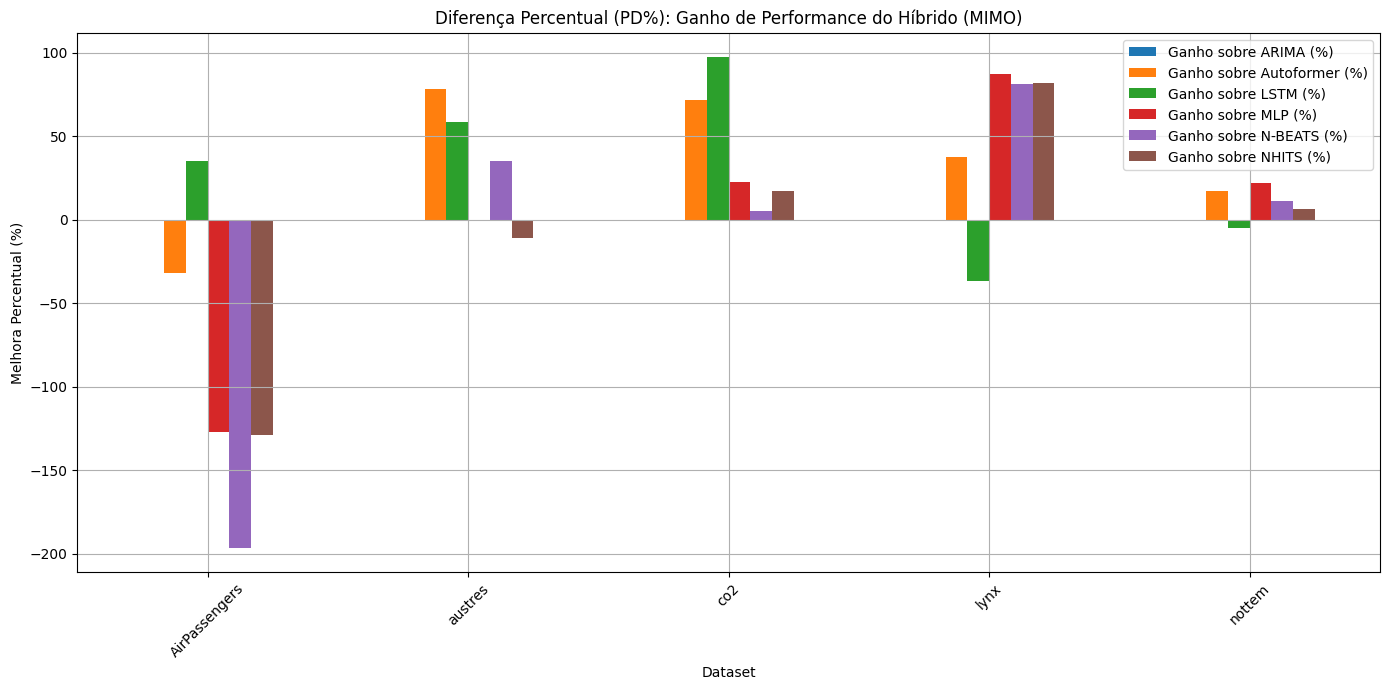



     RELATÓRIO ADICIONAL: TABELA DE RANKING POR MAPE (ESTILO ARTIGO)


dataset,AirPassengers,austres,co2,lynx,nottem,Média,Mediana
Modelo,,,,,,,
ARIMA,5.0,3.0,1.0,2.0,3.0,2.8,2.9
Autoformer,4.0,7.0,6.0,4.0,6.0,5.4,5.7
Híbrido (MIMO),6.0,4.0,2.0,3.0,2.0,3.4,3.2
LSTM,7.0,6.0,7.0,1.0,1.0,4.4,5.2
MLP,3.0,2.0,5.0,7.0,7.0,4.8,4.9
N-BEATS,1.0,5.0,3.0,5.0,5.0,3.8,4.4
NHITS,2.0,1.0,4.0,6.0,4.0,3.4,3.7




     RELATÓRIO ADICIONAL: GRÁFICO DE DIFERENÇA PERCENTUAL AGREGADO (ESTILO FIGURA 9)


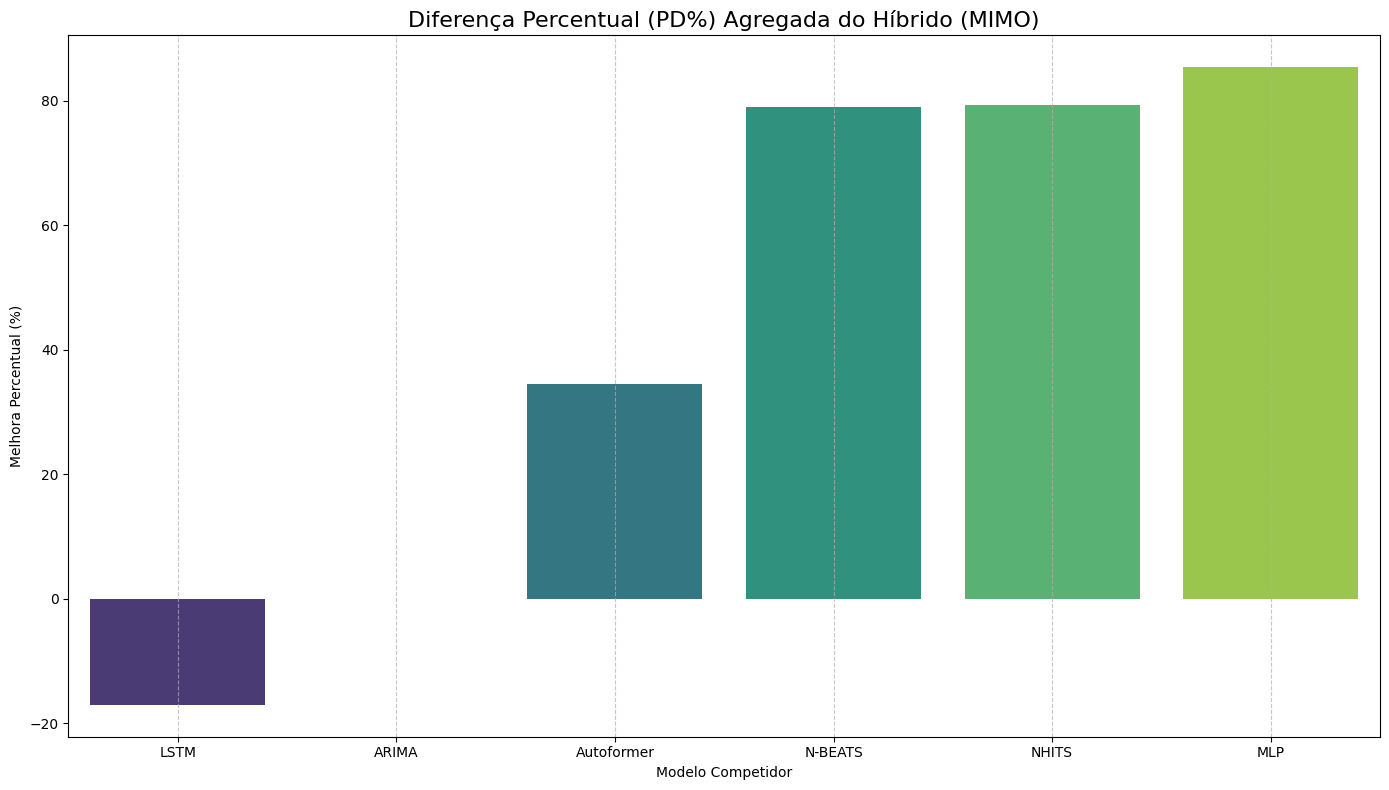



     RELATÓRIO 6: ANÁLISE ESTATÍSTICA GLOBAL (FRIEDMAN + NEMENYI, HORIZONTE 24)

--- Teste de Friedman ---
p-valor: 0.4832

**Conclusão: Não há evidência de uma diferença estatística significativa entre os modelos.**


In [57]:
VETOR_DE_HORIZONTES = [10, 12, 15, 24] # Defina os horizontes que foram testados
gerar_suite_completa_de_relatorios(output_file, VETOR_DE_HORIZONTES)